In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob

from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam

from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers import Bidirectional
from keras.layers import add

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

from keras.models import Model
from keras.utils import to_categorical

2023-06-18 20:41:55.612917: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1,0,2,3"

In [3]:
token_path = "../dataset/my_dataset/captions2.txt"
images_path = '../dataset/my_dataset/train/'
glove_path = '../dataset/glove'

In [4]:
doc = open(token_path,'r').read()
print(doc[:410])

0001.jpg#0 an aerial view of a town with lots of buildings and trees
0001.jpg#1 a town with lots of tall buildings and trees
0001.jpg#2 an aerial view of a town with tall buildings
0001.jpg#3 a group of under construction buildings in a town with lots of trees around
0002.jpg#0 an aerial view of a town with lots of buildings and trees
0002.jpg#1 a town with many buildings and trees
0002.jpg#2 a lot of build


In [5]:
descriptions = dict()
all_image_id = []
for line in doc.split('\n'):
    tokens = line.split()
    if len(line) > 2:
        image_id = tokens[0].split('.')[0]
        image_desc = ' '.join(tokens[1:])
        if image_id not in all_image_id:
            all_image_id.append(image_id)
        if image_id not in descriptions:
            descriptions[image_id] = list()
        descriptions[image_id].append(image_desc)

In [6]:
print("Total images:",len(all_image_id))

Total images: 1256


In [7]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

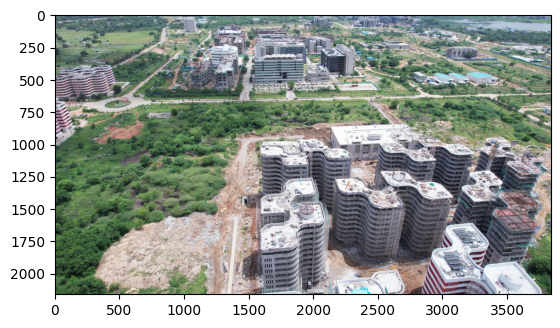

['an aerial view of a town with lots of buildings and trees',
 'a town with lots of tall buildings and trees',
 'an aerial view of a town with tall buildings',
 'a group of under construction buildings in a town with lots of trees around']

In [8]:
pic = '0001.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['0001']

In [9]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]

print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 878


In [10]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(all_image_id,test_size=0.15,random_state = 42)
train, val = train_test_split(train,test_size=0.177,random_state = 42)
print(len(train))
print(len(test))
print(len(val))

878
189
189


In [14]:
print('Train Dataset size: %d' % len(train))

Train Dataset size: 878


In [15]:
img = glob.glob(images_path + '*.jpg')
#train_images = train
#print(train_images)
train_img = []
for i in train:
    path = images_path + i + '.jpg'
    train_img.append(path)
        
#test_images = test
test_img = []
for i in test:
    path = images_path + i + '.jpg'
    test_img.append(path)
    
#val
val_img = []
for i in val:
    path = images_path + i + '.jpg'
    val_img.append(path)

In [16]:
print(images_path)
print(train_img[:5])
print(len(train_img))
print(len(test_img))
print(len(val_img))

../dataset/my_dataset/train/
['../dataset/my_dataset/train/0964.jpg', '../dataset/my_dataset/train/1113.jpg', '../dataset/my_dataset/train/0979.jpg', '../dataset/my_dataset/train/1052.jpg', '../dataset/my_dataset/train/0745.jpg']
878
189
189


In [17]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)
    if image_id in val:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

print('Descriptions: train = %d' % len(train_descriptions))

Descriptions: train = 1067


In [18]:
test_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in test:
        if image_id not in test_descriptions:
            test_descriptions[image_id] = list()
        desc = ' '.join(image_desc)
        test_descriptions[image_id].append(desc)
    

print('Descriptions: test = %d' % len(test_descriptions))

Descriptions: test = 189


In [19]:
all_train_captions = []
for key, val1 in train_descriptions.items():
    for cap in val1:
        all_train_captions.append(cap)
len(all_train_captions)

4268

In [20]:
word_count_threshold = 1
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 844


In [21]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [22]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

845

In [23]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc

max_length = max(len(d.split()) for d in lines)
print('Description Length: %d' % max_length)

Description Length: 24


In [24]:
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [25]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [26]:
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

2023-06-18 20:42:15.189191: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-18 20:42:18.422197: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30482 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0
2023-06-18 20:42:18.423711: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 140 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2023-06-18 20:42:18.425868: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica

In [27]:
from tensorflow.keras.preprocessing import image

In [28]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [29]:
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [30]:
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)

train_features = encoding_train

2023-06-18 20:42:23.110159: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-06-18 20:42:23.752448: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


1/1 [==============================] - 0s 34ms/step


In [31]:
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

1/1 [==============================] - 0s 33ms/step


In [32]:
encoding_val = {}
for img in val_img:
    encoding_val[img[len(images_path):]] = encode(img)

1/1 [==============================] - 0s 38ms/step


In [33]:
val_features = encoding_val
test_features = encoding_test

In [34]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(512, activation='relu')(fe1)


inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(512)(se2)


decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 24)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 24, 200)      169000      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [35]:
from keras.layers import GRU

In [62]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(512, activation='relu')(fe1)


inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = GRU(512)(se2)


decoder1 = add([fe2, se3])
decoder2 = Dense(512, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 24)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 24, 200)      169000      ['input_5[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_4[0][0]']                
                                                                                            

In [63]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [64]:
def data_generator(descriptions, img_id, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            if key not in img_id:
                continue
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [65]:
epochs = 25
batch_size = 64
steps = len(train_descriptions)//batch_size

In [66]:
train_val_features = train_features|val_features

In [67]:
generator_train = data_generator(train_descriptions, train, train_val_features, wordtoix, max_length, batch_size)
generator_val = data_generator(train_descriptions, val, train_val_features, wordtoix, max_length, batch_size)
history = model.fit(generator_train, validation_data=generator_val, validation_steps=5, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/25
16/16 [==============================] - 6s 202ms/step - loss: 5.0886 - val_loss: 4.4677
Epoch 2/25
16/16 [==============================] - 2s 139ms/step - loss: 4.3240 - val_loss: 4.0977
Epoch 3/25
16/16 [==============================] - 2s 144ms/step - loss: 4.0399 - val_loss: 3.8451
Epoch 4/25
16/16 [==============================] - 2s 139ms/step - loss: 3.7427 - val_loss: 3.6279
Epoch 5/25
16/16 [==============================] - 2s 139ms/step - loss: 3.4773 - val_loss: 3.2620
Epoch 6/25
16/16 [==============================] - 2s 149ms/step - loss: 3.1174 - val_loss: 2.9532
Epoch 7/25
16/16 [==============================] - 2s 141ms/step - loss: 2.7696 - val_loss: 2.7732
Epoch 8/25
16/16 [==============================] - 2s 147ms/step - loss: 2.6472 - val_loss: 2.6366
Epoch 9/25
16/16 [==============================] - 2s 140ms/step - loss: 2.5033 - val_loss: 2.5544
Epoch 10/25
16/16 [==============================] - 2s 140ms/step - loss: 2.3704 - val_loss: 2.4237

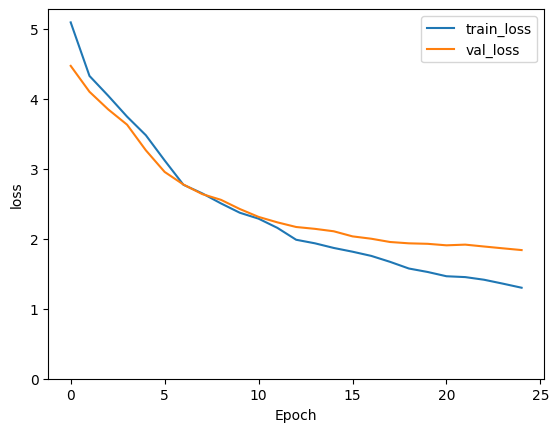

In [68]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()

0395.jpg


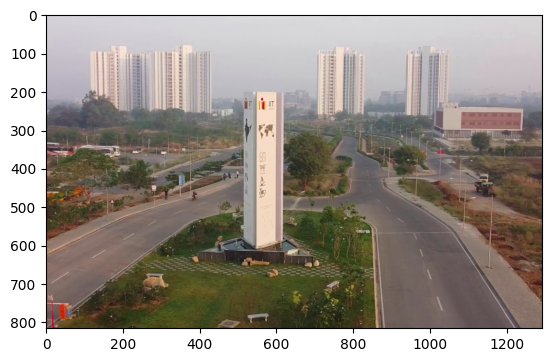

--------------- InceptionV3 + GRU ---------------
Greedy: a white tower with a white tower
Beam (N = 3): an aerial view of an empty road with a tall white tower nearby
Beam (N = 5): an aerial view of an empty road with a tall white tower nearby


In [69]:
pic = list(encoding_test.keys())[18]
print(pic)
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
print("--------------- InceptionV3 + GRU ---------------")
print("Greedy:",greedySearch(image))
print("Beam (N = 3):",beam_search_predictions(image, beam_index = 3))
print("Beam (N = 5):",beam_search_predictions(image, beam_index = 5))

In [43]:
from keras.utils import pad_sequences

In [44]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [45]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual = list()
greedy_predicted = list()
beam3_predicted = list()
beam5_predicted = list()
beam7_predicted = list()

i = 0
for key in test:
    print(i)
    i+=1
    # get actual caption
    captions = test_descriptions[key]
    actual_captions = [caption.split() for caption in captions]
    actual.append(actual_captions)
    
    pic = key + '.jpg'
    image = encoding_test[pic].reshape((1,2048))
    
    #greedy
    y_pred = greedySearch(image)
    y_pred = y_pred.split()
    greedy_predicted.append(y_pred)
    
    
    #beam n=3
    y_pred = beam_search_predictions(image,3)
    y_pred = y_pred.split()
    beam3_predicted.append(y_pred)
    
    #beam n=5
    y_pred = beam_search_predictions(image,5)
    y_pred = y_pred.split()
    beam5_predicted.append(y_pred)
    
    #beam n=7
    #y_pred = beam_search_predictions(image,7)
    #y_pred = y_pred.split()
    #beam7_predicted.append(y_pred)
    
    #predicted.append(y_pred)

In [ ]:
print("Greedy score:")
print("BLEU-1: %f" % corpus_bleu(actual, greedy_predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, greedy_predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, greedy_predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, greedy_predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
print("Beam 3 score:")
print("BLEU-1: %f" % corpus_bleu(actual, beam3_predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, beam3_predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, beam3_predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, beam3_predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
print("Beam 5 score:")
print("BLEU-1: %f" % corpus_bleu(actual, beam5_predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, beam5_predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, beam5_predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, beam5_predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
print(len(actual))
print(len(greedy_predicted))
print(len(beam3_predicted))
print(len(beam5_predicted))

In [ ]:
#beam5_predicted[0]

In [ ]:
from rouge import Rouge
from nltk.translate import meteor_score

In [ ]:
all_r1 = []
all_r2 = []
all_rl = []
all_m = []
#s = 0
for i in range(len(actual)):
    #print(s)
    #s+=1
    
    actual_captions = actual[i]
    generated_tokens = greedy_predicted[i]
    #print("predicted: ",generated_tokens)
    rouge = Rouge()
    
    rouge_scores = []
    m_score = []
    reference_tokens = []
    
    for actual_caption in actual_captions:
        reference_tokens = actual_caption
        #print("ref tokens: ",reference_tokens)
        scores = rouge.get_scores(' '.join(generated_tokens), ' '.join(actual_caption))
        rouge_scores.append(scores[0])
        
        meteor_score_value = meteor_score.meteor_score([reference_tokens], generated_tokens)
        m_score.append(meteor_score_value)
    
    #print("rouge:", rouge_scores)
    #print("m:", m_score)
    
    m = sum(m_score)/len(m_score)
    m_score = []
    all_m.append(m)
    
    r1 = []
    r2 = []
    rl = []
    for i, actual_caption in enumerate(actual_captions):
        #print(f"Actual Caption {i+1}: {actual_caption}")
        #print("ROUGE scores:", rouge_scores[i])
        r1.append(rouge_scores[i]['rouge-1']['f'])
        r2.append(rouge_scores[i]['rouge-2']['f'])
        rl.append(rouge_scores[i]['rouge-l']['f'])
        
    all_r1.append(sum(r1)/4)
    all_r2.append(sum(r2)/4)
    all_rl.append(sum(rl)/4)

print("On greedy:")
print("r1: ",sum(all_r1)/len(all_r1))
print("r2: ",sum(all_r2)/len(all_r2))
print("rl: ",sum(all_rl)/len(all_rl))
print("m: ",sum(all_m)/len(all_m))

In [ ]:
all_r1 = []
all_r2 = []
all_rl = []
all_m = []

for i in range(len(actual)):
    
    actual_captions = actual[i]
    generated_tokens = beam3_predicted[i]
    #print("predicted: ",generated_tokens)
    rouge = Rouge()
    
    rouge_scores = []
    m_score = []
    reference_tokens = []
    
    for actual_caption in actual_captions:
        reference_tokens = actual_caption
        #print("ref tokens: ",reference_tokens)
        scores = rouge.get_scores(' '.join(generated_tokens), ' '.join(actual_caption))
        rouge_scores.append(scores[0])
        
        meteor_score_value = meteor_score.meteor_score([reference_tokens], generated_tokens)
        m_score.append(meteor_score_value)
    
    #print("rouge:", rouge_scores)
    #print("m:", m_score)
    
    m = sum(m_score)/len(m_score)
    m_score = []
    all_m.append(m)
    
    r1 = []
    r2 = []
    rl = []
    for i, actual_caption in enumerate(actual_captions):
        #print(f"Actual Caption {i+1}: {actual_caption}")
        #print("ROUGE scores:", rouge_scores[i])
        r1.append(rouge_scores[i]['rouge-1']['f'])
        r2.append(rouge_scores[i]['rouge-2']['f'])
        rl.append(rouge_scores[i]['rouge-l']['f'])
        
    all_r1.append(sum(r1)/4)
    all_r2.append(sum(r2)/4)
    all_rl.append(sum(rl)/4)

print("On beam 3:")
print("r1: ",sum(all_r1)/len(all_r1))
print("r2: ",sum(all_r2)/len(all_r2))
print("rl: ",sum(all_rl)/len(all_rl))
print("m: ",sum(all_m)/len(all_m))

In [ ]:
all_r1 = []
all_r2 = []
all_rl = []
all_m = []

for i in range(len(actual)):
    
    actual_captions = actual[i]
    generated_tokens = beam5_predicted[i]
    #print("predicted: ",generated_tokens)
    rouge = Rouge()
    
    rouge_scores = []
    m_score = []
    reference_tokens = []
    
    for actual_caption in actual_captions:
        reference_tokens = actual_caption
        #print("ref tokens: ",reference_tokens)
        scores = rouge.get_scores(' '.join(generated_tokens), ' '.join(actual_caption))
        rouge_scores.append(scores[0])
        
        meteor_score_value = meteor_score.meteor_score([reference_tokens], generated_tokens)
        m_score.append(meteor_score_value)
    
    #print("rouge:", rouge_scores)
    #print("m:", m_score)
    
    m = sum(m_score)/len(m_score)
    m_score = []
    all_m.append(m)
    
    r1 = []
    r2 = []
    rl = []
    for i, actual_caption in enumerate(actual_captions):
        #print(f"Actual Caption {i+1}: {actual_caption}")
        #print("ROUGE scores:", rouge_scores[i])
        r1.append(rouge_scores[i]['rouge-1']['f'])
        r2.append(rouge_scores[i]['rouge-2']['f'])
        rl.append(rouge_scores[i]['rouge-l']['f'])
        
    all_r1.append(sum(r1)/4)
    all_r2.append(sum(r2)/4)
    all_rl.append(sum(rl)/4)

print("On beam 5:")
print("r1: ",sum(all_r1)/len(all_r1))
print("r2: ",sum(all_r2)/len(all_r2))
print("rl: ",sum(all_rl)/len(all_rl))
print("m: ",sum(all_m)/len(all_m))

In [90]:
# Save in files

In [1]:
file_name = "greedy.txt"  # Change this to your desired file name
file_path = "./exp5/" + file_name  # Change the path if necessary

# Open the file in write mode
with open(file_path, 'w') as file:
    # Iterate over each element in the array
    for element in predicted1:
        # Write the element to a new line in the file
        file.write(' '.join(element) + '\n')

# Print a message indicating the file creation
print(f"The file '{file_name}' has been created and populated with the array elements.")

NameError: name 'predicted1' is not defined

In [92]:
file_name = "beam3.txt"  # Change this to your desired file name
file_path = "./exp5/" + file_name  # Change the path if necessary

# Open the file in write mode
with open(file_path, 'w') as file:
    # Iterate over each element in the array
    for element in predicted3:
        # Write the element to a new line in the file
        file.write(' '.join(element) + '\n')

# Print a message indicating the file creation
print(f"The file '{file_name}' has been created and populated with the array elements.")

The file 'beam3.txt' has been created and populated with the array elements.


In [93]:
file_name = "beam5.txt"  # Change this to your desired file name
file_path = "./exp5/" + file_name  # Change the path if necessary

# Open the file in write mode
with open(file_path, 'w') as file:
    # Iterate over each element in the array
    for element in predicted5:
        # Write the element to a new line in the file
        file.write(' '.join(element) + '\n')

# Print a message indicating the file creation
print(f"The file '{file_name}' has been created and populated with the array elements.")

The file 'beam5.txt' has been created and populated with the array elements.


In [94]:
file_name = "act1.txt"  # Change this to your desired file name
file_path = "./exp2/" + file_name  # Change the path if necessary

# Open the file in write mode
with open(file_path, 'w') as file:
    # Iterate over each element in the array
    for element in actual:
        el = element[0]
        # Write the element to a new line in the file
        file.write(' '.join(el) + '\n')

# Print a message indicating the file creation
print(f"The file '{file_name}' has been created and populated with the array elements.")

The file 'act1.txt' has been created and populated with the array elements.


In [95]:
file_name = "act2.txt"  # Change this to your desired file name
file_path = "./exp2/" + file_name  # Change the path if necessary

# Open the file in write mode
with open(file_path, 'w') as file:
    # Iterate over each element in the array
    for element in actual:
        el = element[1]
        # Write the element to a new line in the file
        file.write(' '.join(el) + '\n')

# Print a message indicating the file creation
print(f"The file '{file_name}' has been created and populated with the array elements.")

The file 'act2.txt' has been created and populated with the array elements.


In [96]:
file_name = "act3.txt"  # Change this to your desired file name
file_path = "./exp2/" + file_name  # Change the path if necessary

# Open the file in write mode
with open(file_path, 'w') as file:
    # Iterate over each element in the array
    for element in actual:
        el = element[2]
        # Write the element to a new line in the file
        file.write(' '.join(el) + '\n')

# Print a message indicating the file creation
print(f"The file '{file_name}' has been created and populated with the array elements.")

The file 'act3.txt' has been created and populated with the array elements.


In [97]:
file_name = "act4.txt"  # Change this to your desired file name
file_path = "./exp2/" + file_name  # Change the path if necessary

# Open the file in write mode
with open(file_path, 'w') as file:
    # Iterate over each element in the array
    for element in actual:
        el = element[3]
        # Write the element to a new line in the file
        file.write(' '.join(el) + '\n')

# Print a message indicating the file creation
print(f"The file '{file_name}' has been created and populated with the array elements.")

The file 'act4.txt' has been created and populated with the array elements.


0183.jpg


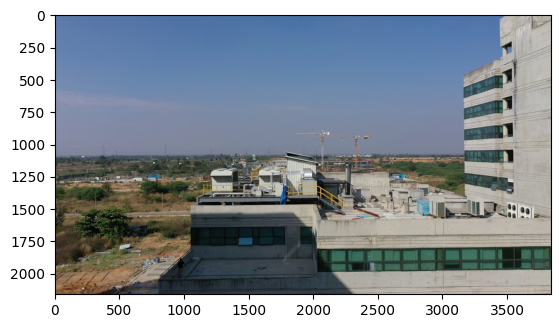

Greedy: a lot of people are standing on a green field in front of building
Beam Search, K = 3: an aerial view of a building with a lot of trees in front of it
Beam Search, K = 5: an aerial view of a building with a lot of cars parked in front of it
Beam Search, K = 7: an aerial view of a building with a lot of cars parked in front of it


In [97]:
pic = list(encoding_test.keys())[0]
print(pic)
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))

In [99]:
actual[0]

[['a', 'view', 'of', 'a', 'building', 'with', 'a', 'crane', 'on', 'top'],
 ['a',
  'view',
  'of',
  'rood',
  'top',
  'of',
  'the',
  'building',
  'with',
  'crane',
  'on',
  'top'],
 ['a',
  'roof',
  'of',
  'the',
  'industrial',
  'building',
  'with',
  'crane',
  'in',
  'the',
  'background'],
 ['a', 'top', 'floor', 'of', 'the', 'building', 'with', 'many', 'windows']]

In [102]:
actual[1]

[['a',
  'large',
  'green',
  'field',
  'with',
  'roads',
  'and',
  'white',
  'buildings'],
 ['two',
  'tall',
  'white',
  'buildings',
  'in',
  'the',
  'background',
  'on',
  'green',
  'field'],
 ['an',
  'aerial',
  'view',
  'of',
  'large',
  'green',
  'field',
  'with',
  'two',
  'white',
  'buildings',
  'in',
  'the',
  'background',
  'and',
  'long',
  'roads'],
 ['an',
  'aerial',
  'view',
  'of',
  'roads',
  'and',
  'buildings',
  'on',
  'green',
  'fram',
  'land']]